## Springboard Data Science Track Capstone Project 2
### Music Genre Classification from Audio Samples
### by Morgan Fry
### Extended Modeling -- Convolutional Neural Net

In [1]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report

import utils

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
else:
    print('no gpu')

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, y_labels = utils.load_mfcc()

In [4]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Reshape((968,24),input_shape=(X_train.shape[1],)))
model.add(layers.Conv1D(16, 1, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 1, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 1, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.0, nesterov=True)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 968, 24)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 968, 16)           400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 484, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 484, 32)           544       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 242, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 242, 32)           1056      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 121, 32)           0

In [5]:
%%time
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              min_delta=0.0001,
                                              patience=30,
                                              restore_best_weights=True)

with tf.device('/GPU:0'):
    history=model.fit(X_train,
              y_train,
              epochs=500,
              batch_size=16,
              callbacks=[early_stop],
              validation_data=(X_val, y_val))

Epoch 1/500
395/395 [==============================] - 1s 4ms/step - loss: 2.0837 - accuracy: 0.1846 - val_loss: 1.9255 - val_accuracy: 0.2409
Epoch 2/500
395/395 [==============================] - 1s 3ms/step - loss: 1.9366 - accuracy: 0.2471 - val_loss: 1.8621 - val_accuracy: 0.2749
Epoch 3/500
395/395 [==============================] - 1s 3ms/step - loss: 1.8632 - accuracy: 0.2935 - val_loss: 1.8211 - val_accuracy: 0.2976
Epoch 4/500
395/395 [==============================] - 1s 3ms/step - loss: 1.8236 - accuracy: 0.3133 - val_loss: 1.7921 - val_accuracy: 0.3317
Epoch 5/500
395/395 [==============================] - 1s 3ms/step - loss: 1.7911 - accuracy: 0.3341 - val_loss: 1.7783 - val_accuracy: 0.3405
Epoch 6/500
395/395 [==============================] - 1s 3ms/step - loss: 1.7750 - accuracy: 0.3371 - val_loss: 1.7551 - val_accuracy: 0.3480
Epoch 7/500
395/395 [==============================] - 1s 3ms/step - loss: 1.7481 - accuracy: 0.3529 - val_loss: 1.7409 - val_accuracy: 0.3506

Epoch 58/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4202 - accuracy: 0.4911 - val_loss: 1.5183 - val_accuracy: 0.4477
Epoch 59/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4212 - accuracy: 0.4865 - val_loss: 1.5211 - val_accuracy: 0.4502
Epoch 60/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4170 - accuracy: 0.4975 - val_loss: 1.5157 - val_accuracy: 0.4515
Epoch 61/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4118 - accuracy: 0.4935 - val_loss: 1.5123 - val_accuracy: 0.4414
Epoch 62/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4045 - accuracy: 0.4886 - val_loss: 1.5154 - val_accuracy: 0.4426
Epoch 63/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4014 - accuracy: 0.4997 - val_loss: 1.5153 - val_accuracy: 0.4502
Epoch 64/500
395/395 [==============================] - 1s 3ms/step - loss: 1.4070 - accuracy: 0.5036 - val_loss: 1.5120 - val_accuracy:

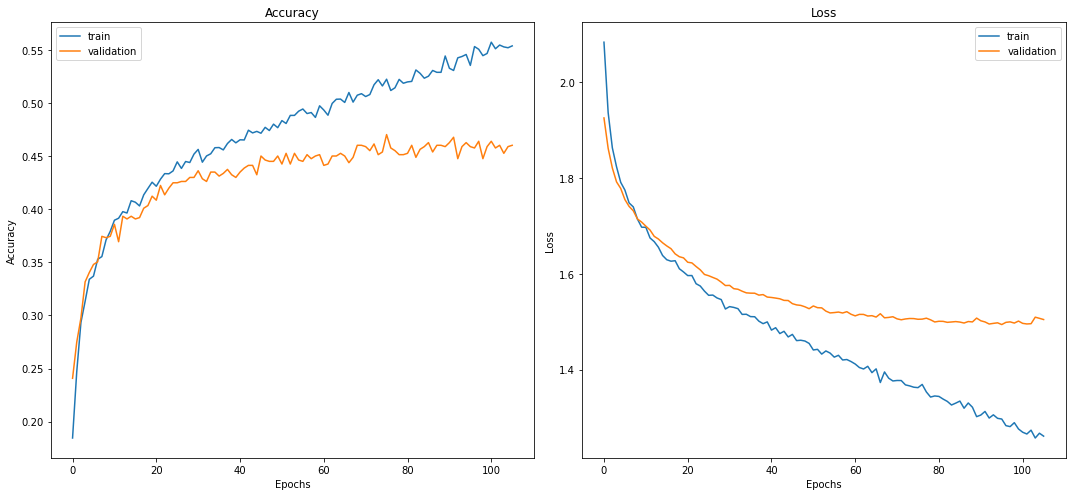

In [6]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

We can see that the accuracy and loss over the validation set diverge from the test set once the model achieves about 45% accuracy on the validation set.

In [7]:
y_pred=np.argmax(model.predict(X_test), axis=-1)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.46      0.44      0.45        96
           1       0.21      0.16      0.18        98
           2       0.19      0.19      0.19       100
           3       0.59      0.75      0.66       100
           4       0.32      0.33      0.33       100
           5       0.44      0.44      0.44       100
           6       0.23      0.20      0.22       100
           7       0.50      0.54      0.52       100

    accuracy                           0.38       794
   macro avg       0.37      0.38      0.37       794
weighted avg       0.37      0.38      0.37       794



Over the set of:  
* 8 classes
* 1000 samples each class

The Convolutional Neural Network shows an improvement over the baseline.

| Model | Accuracy(all classes) | Train Time |
| --- | --- | --- |
| Baseline | .30 | 5m |
| CNN | .38 | 2m 10s |
